为什么需要批量规范化层呢？让我们来回顾一下训练神经网络时出现的一些实际挑战。

首先，数据预处理的方式通常会对最终结果产生巨大影响。 回想一下我们应用多层感知机来预测房价的例子（ 4.10节）。 使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。 直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。

第二，对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测。 批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。 直观地说，我们可能会猜想，如果一个层的可变值是另一层的100倍，这可能需要对学习率进行补偿调整。

第三，更深层的网络很复杂，容易过拟合。 这意味着正则化变得更加重要。

批量规范化应用于单个可选层（也可以应用到所有层），其原理如下：
##### 在每次训练迭代中，我们首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。 接下来，我们应用比例系数和比例偏移。
正是由于这个基于批量统计的标准化，才有了批量规范化的名称。

#### 请注意，如果我们尝试使用大小为1的小批量应用批量规范化，我们将无法学到任何东西。 这是因为在减去均值之后，每个隐藏单元将为0。
所以，只有使用足够大的小批量，批量规范化这种方法才是有效且稳定的。 请注意，在应用批量规范化时，批量大小的选择可能比没有批量规范化时更重要。

从形式上说，用x∈β表示一个来自小批量β的输入，批量规范化BN根据以下表达式转换x
![BN](imgs/7_5_1训练深层网络BN1.png)

请注意，我们在方差估计值中添加一个小常量 ϵ>0 ，以确保我们永远不会尝试除以零，即使在经验方差估计值可能消失的情况下也是如此。估计值 μ^B 和 σ^B 通过使用平均值和方差的噪声（noise）估计来抵消缩放问题。 你可能会认为这种噪声是一个问题，而事实上它是有益的。

### 7.5.2. 批量规范化层
回想一下，批量规范化和其他图层之间的一个关键区别是，由于批量规范化在完整的小批次上运行，因此我们不能像以前在引入其他图层时那样忽略批处理的尺寸大小。 我们在下面讨论这两种情况：全连接层和卷积层，他们的批量规范化实现略有不同。

#### 7.5.2.1. 全连接层
##### 通常，我们将批量规范化层置于全连接层中的仿射变换和激活函数之间。
设全连接层的输入为u，权重参数和偏置参数分别为 W 和 b ，激活函数为 ϕ ，批量规范化的运算符为 BN 。 那么，使用批量规范化的全连接层的输出的计算详情如下：


$$h=ϕ(BN(Wx+b))$$

回想一下，均值和方差是在应用变换的“相同”小批量上计算的。
#### 7.5.2.2. 卷积层
同样，对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用批量规范化。 当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执行批量规范化，每个通道都有自己的拉伸（scale）和偏移（shift）参数，这两个参数都是标量。 假设我们的微批次包含 m 个示例，并且对于每个通道，卷积的输出具有高度 p 和宽度 q 。 那么对于卷积层，我们在每个输出通道的 m⋅p⋅q 个元素上同时执行每个批量规范化。 因此，在计算平均值和方差时，我们会收集所有空间位置的值，
##### 然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行规范化。

#### 7.5.2.3. 预测过程中的批量规范化
正如我们前面提到的，批量规范化在训练模式和预测模式下的行为通常不同。 首先，将训练好的模型用于预测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。 其次，例如，我们可能需要使用我们的模型对逐个样本进行预测。 一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出。 可见，和暂退法一样，批量规范化层在训练模式和预测模式下的计算结果也是不一样的。

### 7.5.3. 从零实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
def batch_normal(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled判断是训练还是预测模式
    if not torch.is_grad_enabled():
        # 如果是预测模式，直接使用传入的移动平均和方差做标准化
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert  len(X.shape) in (2, 4) # 全连接或者卷积
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维度上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积的情况，计算通道维度（axis=1）的均值和方差
            # 这里需要保持X的形状，以便后面做广播计算
            mean = X.mean(dim=(0,2,3), keep_dim=True)
            var = ((X - mean) ** 2).mean(dim=(0,2,3), keep_dim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X-mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和移位
    return Y, moving_mean.data, moving_var.data

撇开算法细节，注意我们设计图层的基础设计模式。
通常情况下，我们用一个单独的函数定义其数学原理，比如说batch_norm。 然后，我们将此功能集成到一个自定义层中

In [6]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

training on cuda:0


RuntimeError: DataLoader worker (pid(s) 18768, 3084, 10244, 2644) exited unexpectedly

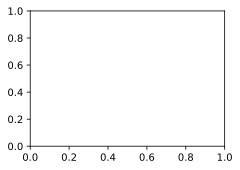

In [8]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [9]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1., 1., 1., 1., 1., 1.], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([0., 0., 0., 0., 0., 0.], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [10]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

training on cuda:0


RuntimeError: DataLoader worker (pid(s) 12476, 5280, 15968, 9732) exited unexpectedly

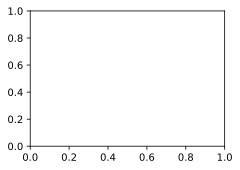

In [11]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())